In [63]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [64]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from time import  time

from torchvision.utils import make_grid
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import random

from bhsgan import DiscriminatorBhsMnist, GeneratorBhsMnist
from ipmbhsgan import DiscriminatorIpmMnist, GeneratorIpmMnist
from trainer import *
from utils import *
#get_device, get_noise, init_weights, plot_tensor_images, plot_losses, Positive, RevKlActivation
from wgan import DiscriminatorWassersteinMnist, GeneratorWassersteinMnist
from torch.utils.tensorboard import SummaryWriter

In [65]:
# create dataloader
batch_size = 128
device = get_device()

train_transform = transforms.Compose([
    transforms.ToTensor(),
])

dataloader = DataLoader(
    MNIST('.', download=True, transform=train_transform),
    batch_size=batch_size,
    shuffle=True)

Time is 0.012010812759399414 sec
Shape of loading one batch: torch.Size([128, 1, 28, 28])
Total no. of batches present in trainloader: 469


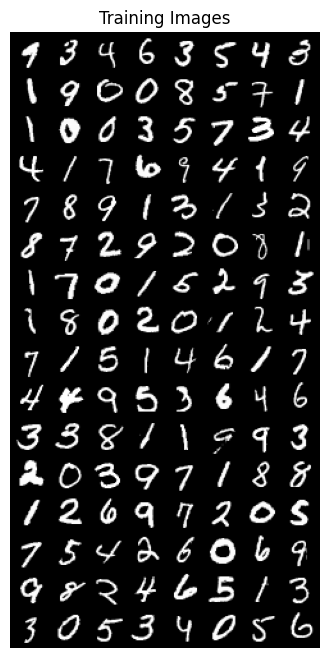

In [66]:
start = time()
dataiter = iter(dataloader)
images,labels = dataiter._next_data()
print ('Time is {} sec'.format(time()-start))

plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(make_grid(images.to(device), padding=2, normalize=True).cpu(),(1,2,0)))

print('Shape of loading one batch:', images.shape)
print('Total no. of batches present in trainloader:', len(dataloader))

In [67]:
latent_dim = 100
latent_dim_bhs = 28*28
batch_size_bhs = 128
test_noise = get_noise(25, latent_dim, device)
test_noise_bhs = get_noise(25, latent_dim_bhs, device)

## First I train a Wasserstein GAN

In [69]:
torch.manual_seed(96)
random.seed(96)

training_params = TrainingParams(lr_dis=0.0002,
                                 lr_gen=0.0002,
                                 num_epochs=50,
                                 num_dis_updates=4,
                                 num_gen_updates=3,
                                 beta_1=0.5,
                                 batch_size=batch_size)

In [70]:
generator_wasserstein = GeneratorWassersteinMnist(latent_dim).apply(init_weights)
discriminator_wasserstein = DiscriminatorWassersteinMnist(28*28).apply(init_weights)
trainer_wgan = Trainer(training_params, generator_wasserstein, discriminator_wasserstein, device=device)

In [71]:
# training loop
trained_wgan = trainer_wgan.train_gan(dataloader, get_dis_loss_wasserstein, get_gen_loss_wasserstein, True, flatten_dim=28*28)

Epoch 1 start training...
Epoch: 1/50 Total Steps:469poch_Run_Time: 16.481350	Loss_C : -1.697189	Loss_G : -3.929598	
Total_Time : 16.482351
Loss_C : -1.697189
Loss_G : -3.929598
Loss_C_Mean : -1.831544
Loss_G_Mean : -1.019035

----------------------------------------------

Epoch 2 start training...
Epoch: 2/50 Total Steps:938poch_Run_Time: 15.885262	Loss_C : -1.110030	Loss_G : -5.992853	
Total_Time : 15.887264
Loss_C : -1.110030
Loss_G : -5.992853
Loss_C_Mean : -1.394962
Loss_G_Mean : -4.715954

----------------------------------------------

Epoch 3 start training...
Epoch: 3/50 Total Steps:1407och_Run_Time: 15.783746	Loss_C : -1.057435	Loss_G : -5.359712	
Total_Time : 15.785748
Loss_C : -1.057435
Loss_G : -5.359712
Loss_C_Mean : -1.065499
Loss_G_Mean : -5.188088

----------------------------------------------

Epoch 4 start training...
Epoch: 4/50 Total Steps:1876och_Run_Time: 15.956887	Loss_C : -0.936879	Loss_G : -5.641266	
Total_Time : 15.957887
Loss_C : -0.936879
Loss_G : -5.6412

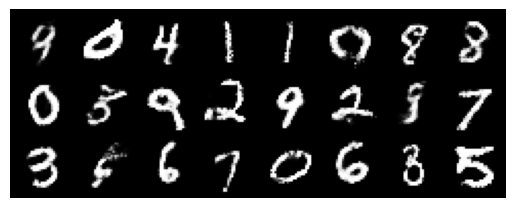

In [98]:
# show generated images
torch.manual_seed(12)
test_noise = get_noise(25, latent_dim, device)
generated_images_wasserstein = trained_wgan.generator(test_noise)
plot_tensor_images(generated_images_wasserstein, num_images=24)

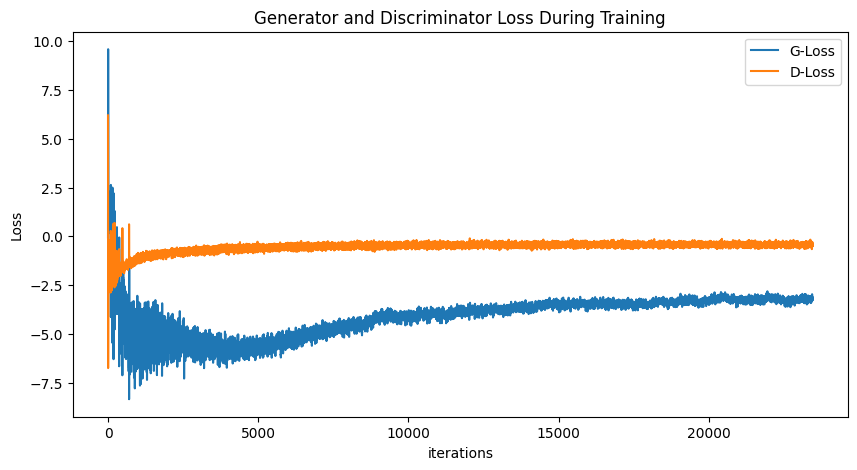

In [75]:
# plot losses
plot_losses(trained_wgan.generator_losses, trained_wgan.discriminator_losses)

Save model Parameters

In [237]:
torch.save(generator_wasserstein.state_dict(), "C:/Users/Rick/Desktop/bhsgan/State_Dicts/WS_Gen.pt")
torch.save(discriminator_wasserstein.state_dict(), "C:/Users/Rick/Desktop/bhsgan/State_Dicts/WS_Disc.pt")

## BHS Gan
$f^*(x) = 2(-1+\sqrt{1+x})\exp(\sqrt{1+x})$

In [76]:
torch.manual_seed(96)
random.seed(96)

training_params_bhs = TrainingParams(lr_dis=0.0002, lr_gen=0.0002, num_epochs=50, num_dis_updates=4, num_gen_updates=3, beta_1=0.5, batch_size=batch_size_bhs)
generator_bhs = GeneratorBhsMnist(latent_dim_bhs)
discriminator_bhs = DiscriminatorBhsMnist(Positive, 28*28)
trainer_bhs = Trainer(training_params_bhs, generator_bhs, discriminator_bhs, device=device)

In [77]:
trained_bhsgan = trainer_bhs.train_gan(dataloader, get_dis_loss_bhs, get_gen_loss_bhs, False, flatten_dim=28*28)

Epoch 1 start training...
Epoch: 1/50 Total Steps:469poch_Run_Time: 14.679633	Loss_C : 0.033616	Loss_G : -0.103953		
Total_Time : 14.680635
Loss_C : 0.033616
Loss_G : -0.103953
Loss_C_Mean : 0.023251
Loss_G_Mean : -0.188927

----------------------------------------------

Epoch 2 start training...
Epoch: 2/50 Total Steps:938poch_Run_Time: 14.462718	Loss_C : 0.063386	Loss_G : -0.106358		
Total_Time : 14.463719
Loss_C : 0.063386
Loss_G : -0.106358
Loss_C_Mean : 0.020632
Loss_G_Mean : -0.083835

----------------------------------------------

Epoch 3 start training...
Epoch: 3/50 Total Steps:1407och_Run_Time: 14.757414	Loss_C : 0.028972	Loss_G : -0.076717		
Total_Time : 14.758415
Loss_C : 0.028972
Loss_G : -0.076717
Loss_C_Mean : 0.009469
Loss_G_Mean : -0.067372

----------------------------------------------

Epoch 4 start training...
Epoch: 4/50 Total Steps:1876och_Run_Time: 14.457139	Loss_C : 0.004893	Loss_G : -0.045236		
Total_Time : 14.457139
Loss_C : 0.004893
Loss_G : -0.045236
Loss

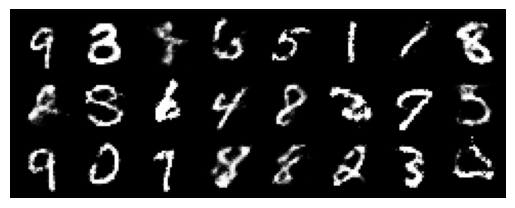

In [97]:
# show generated images
torch.manual_seed(12)
test_noise_bhs = get_noise(24, latent_dim_bhs, device)
generated_images_bhs = trained_bhsgan.generator(test_noise_bhs)
plot_tensor_images(generated_images_bhs, num_images=24)

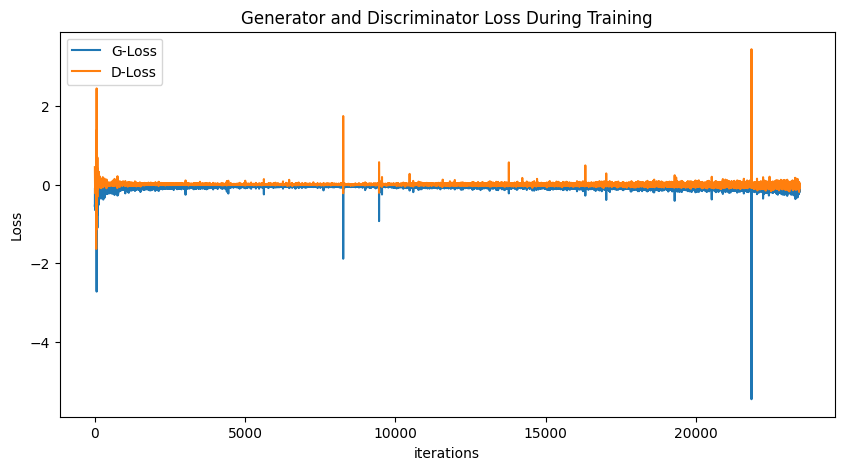

In [80]:
# plot losses
plot_losses(trained_bhsgan.generator_losses, trained_bhsgan.discriminator_losses)

In [238]:
torch.save(generator_bhs.state_dict(), "C:/Users/Rick/Desktop/bhsgan/State_Dicts/BHS_Gen.pt")
torch.save(discriminator_bhs.state_dict(), "C:/Users/Rick/Desktop/bhsgan/State_Dicts/BHS_Disc.pt")

## KL GAN
$f^*(x) = \exp(x-1)$


In [100]:
torch.manual_seed(96)
random.seed(96)

training_params_KL = TrainingParams(lr_dis=0.0002, lr_gen=0.0002, num_epochs=50, num_dis_updates=4, num_gen_updates=3, beta_1=0.5, batch_size=batch_size_bhs)
generator_KL = GeneratorBhsMnist(latent_dim_bhs)
discriminator_KL = DiscriminatorBhsMnist(nn.Identity, 28*28)
trainer_kl = Trainer(training_params_KL, generator_KL, discriminator_KL, device=device)

In [101]:
trained_klgan = trainer_kl.train_gan(dataloader, get_dis_loss_kl, get_gen_loss_kl, False, flatten_dim=28*28)

Epoch 1 start training...
Epoch: 1/50 Total Steps:469poch_Run_Time: 14.270182	Loss_C : -0.916605	Loss_G : -0.874183	
Total_Time : 14.271183
Loss_C : -0.916605
Loss_G : -0.874183
Loss_C_Mean : -0.498125
Loss_G_Mean : -0.702456

----------------------------------------------

Epoch 2 start training...
Epoch: 2/50 Total Steps:938poch_Run_Time: 13.807702	Loss_C : -0.550315	Loss_G : -0.840650	
Total_Time : 13.808704
Loss_C : -0.550315
Loss_G : -0.840650
Loss_C_Mean : -0.380776
Loss_G_Mean : -0.806670

----------------------------------------------

Epoch 3 start training...
Epoch: 3/50 Total Steps:1407och_Run_Time: 13.832679	Loss_C : -0.370341	Loss_G : -1.071776	
Total_Time : 13.833680
Loss_C : -0.370341
Loss_G : -1.071776
Loss_C_Mean : -0.417530
Loss_G_Mean : -0.937486

----------------------------------------------

Epoch 4 start training...
Epoch: 4/50 Total Steps:1876och_Run_Time: 13.668588	Loss_C : -0.217428	Loss_G : -0.951339	
Total_Time : 13.669589
Loss_C : -0.217428
Loss_G : -0.9513

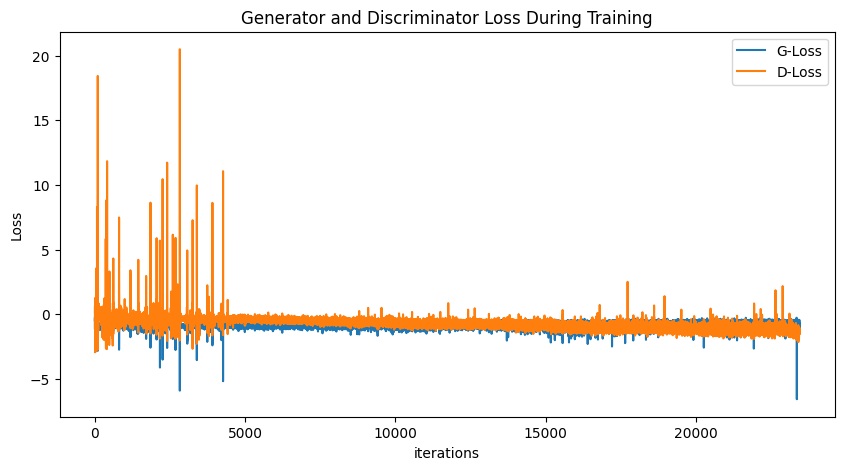

In [103]:
plot_losses(trained_klgan.generator_losses, trained_klgan.discriminator_losses)

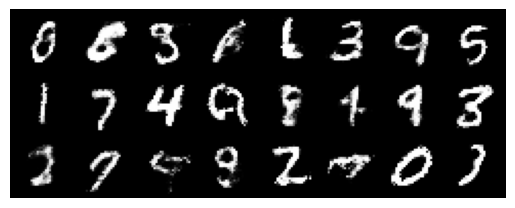

In [107]:
torch.manual_seed(12)
test_noise_bhs = get_noise(24, latent_dim_bhs, device)
generated_images_kl = trained_klgan.generator(test_noise_bhs)
plot_tensor_images(generated_images_kl, num_images=25)

In [239]:
torch.save(generator_KL.state_dict(), "C:/Users/Rick/Desktop/bhsgan/State_Dicts/KL_Gen.pt")
torch.save(discriminator_KL.state_dict(), "C:/Users/Rick/Desktop/bhsgan/State_Dicts/KL_Disc.pt")

## Rev KL GAN
$f^*(x) = -1 - \log(x)$


In [108]:
torch.manual_seed(96)
random.seed(96)

training_params_RKL = TrainingParams(lr_dis=0.0002,
                                     lr_gen=0.0002,
                                     num_epochs=50,
                                     num_dis_updates=4,
                                     num_gen_updates=3,
                                     beta_1=0.5,
                                     batch_size=batch_size_bhs)
generator_RKL = GeneratorBhsMnist(latent_dim_bhs)
discriminator_RKL = DiscriminatorBhsMnist(RevKlActivation, 28 * 28)
trainer_rkl = Trainer(training_params_RKL, generator_RKL, discriminator_RKL, device=device)


In [109]:
trained_rklgan = trainer_rkl.train_gan(dataloader, get_dis_loss_rkl, get_gen_loss_rkl, False, flatten_dim=28 * 28)

Epoch 1 start training...
Epoch: 1/50 Total Steps:469poch_Run_Time: 14.958718	Loss_C : 0.348685	Loss_G : -0.333308	
Total_Time : 14.959719
Loss_C : 0.348685
Loss_G : -0.333308
Loss_C_Mean : 0.363414
Loss_G_Mean : -0.343889

----------------------------------------------

Epoch 2 start training...
Epoch: 2/50 Total Steps:938poch_Run_Time: 14.828515	Loss_C : 0.380608	Loss_G : -0.330329	
Total_Time : 14.829516
Loss_C : 0.380608
Loss_G : -0.330329
Loss_C_Mean : 0.361102
Loss_G_Mean : -0.291029

----------------------------------------------

Epoch 3 start training...
Epoch: 3/50 Total Steps:1407och_Run_Time: 15.194679	Loss_C : 0.372282	Loss_G : -0.335834	
Total_Time : 15.195680
Loss_C : 0.372282
Loss_G : -0.335834
Loss_C_Mean : 0.370676
Loss_G_Mean : -0.338693

----------------------------------------------

Epoch 4 start training...
Epoch: 4/50 Total Steps:1876och_Run_Time: 14.585115	Loss_C : 0.373563	Loss_G : -0.352153	
Total_Time : 14.586116
Loss_C : 0.373563
Loss_G : -0.352153
Loss_C_M

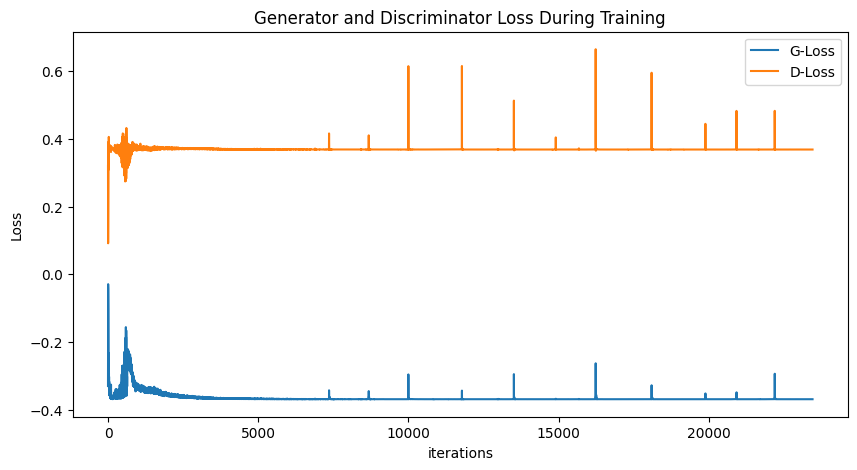

In [110]:
plot_losses(trained_rklgan.generator_losses, trained_rklgan.discriminator_losses)

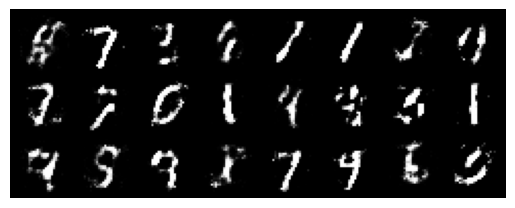

In [112]:
torch.manual_seed(12)
test_noise_bhs = get_noise(24, latent_dim_bhs, device)
generated_images_rkl = trained_rklgan.generator(test_noise_bhs)
plot_tensor_images(generated_images_rkl, num_images=25)

In [240]:
torch.save(generator_RKL.state_dict(), "C:/Users/Rick/Desktop/bhsgan/State_Dicts/RKL_Gen.pt")
torch.save(discriminator_RKL.state_dict(), "C:/Users/Rick/Desktop/bhsgan/State_Dicts/RKL_Disc.pt")

## Pearson GAN
$f^*(x) = \frac{1}{4} x^2 + x$

In [133]:
torch.manual_seed(96)
random.seed(96)

training_params_pgan = TrainingParams(lr_dis=0.0002,
                                      lr_gen=0.002,
                                      num_epochs=8,
                                      num_dis_updates=1,
                                      num_gen_updates=3,
                                      beta_1=0.5,
                                      batch_size=batch_size_bhs)
generator_pgan = GeneratorBhsMnist(latent_dim_bhs)
discriminator_pgan = DiscriminatorBhsMnist(nn.Identity,28 * 28)
trainer_kl = Trainer(training_params_pgan, generator_pgan, discriminator_pgan, device=device)


In [134]:
trained_pgan = trainer_kl.train_gan(dataloader, get_dis_loss_p, get_gen_loss_p, False, flatten_dim=28 * 28)

Epoch 1 start training...


KeyboardInterrupt: 

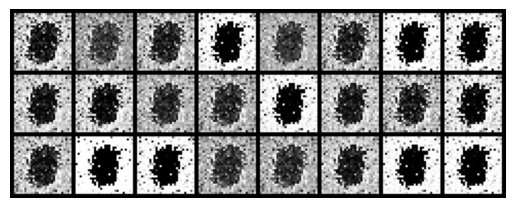

In [126]:
torch.manual_seed(12)
test_noise_bhs = get_noise(24, latent_dim_bhs, device)

generated_images_pgan = trained_pgan.generator(test_noise_bhs)
plot_tensor_images(generated_images_pgan, num_images=24)


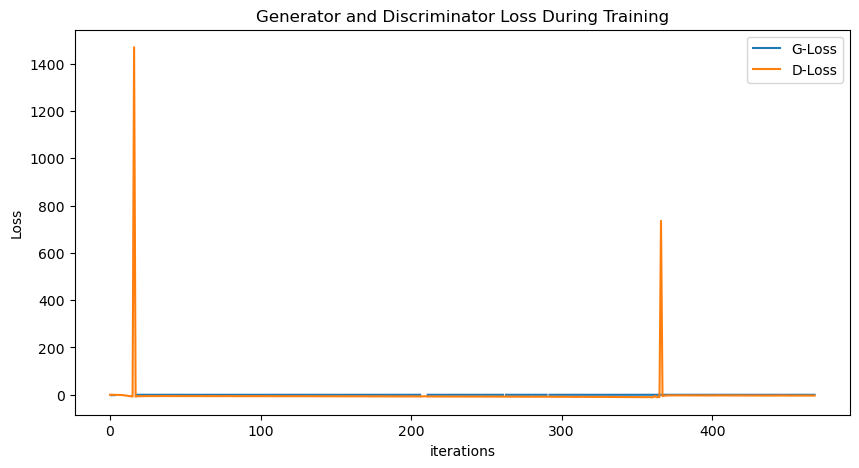

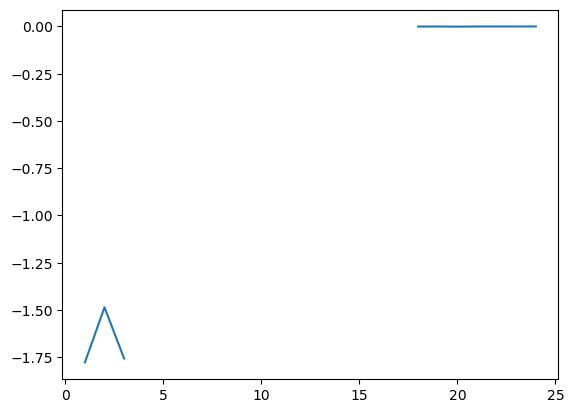

In [35]:
plot_losses(trained_pgan.generator_losses, trained_pgan.discriminator_losses)
plt.plot(trained_pgan.generator_losses[0:25])

## GAN GAN
$f^*(x) = -\log(1-\exp(x))$

In [135]:
torch.manual_seed(96)
random.seed(96)

training_params_GAN = TrainingParams(lr_dis=0.0002, lr_gen=0.0002, num_epochs=50, num_dis_updates=4, num_gen_updates=3,
                                    beta_1=0.5, batch_size=batch_size_bhs)
generator_GAN = GeneratorBhsMnist(latent_dim_bhs)
discriminator_GAN = DiscriminatorBhsMnist(RevKlActivation, 28 * 28)
trainer_gan = Trainer(training_params_GAN, generator_GAN, discriminator_GAN, device=device)

In [136]:
trained_gan = trainer_gan.train_gan(dataloader, get_dis_loss_gan, get_gen_loss_gan, False, flatten_dim=28 * 28)

Epoch 1 start training...
Epoch: 1/50 Total Steps:469poch_Run_Time: 14.429132	Loss_C : 0.036375	Loss_G : -0.092705	
Total_Time : 14.430134
Loss_C : 0.036375
Loss_G : -0.092705
Loss_C_Mean : 0.089306
Loss_G_Mean : -0.218454

----------------------------------------------

Epoch 2 start training...
Epoch: 2/50 Total Steps:938poch_Run_Time: 14.297861	Loss_C : 0.017354	Loss_G : -0.019915	
Total_Time : 14.298863
Loss_C : 0.017354
Loss_G : -0.019915
Loss_C_Mean : 0.023833
Loss_G_Mean : -0.036993

----------------------------------------------

Epoch 3 start training...
Epoch: 3/50 Total Steps:1407och_Run_Time: 14.790047	Loss_C : 0.006632	Loss_G : -0.000839	
Total_Time : 14.791049
Loss_C : 0.006632
Loss_G : -0.000839
Loss_C_Mean : 0.010912
Loss_G_Mean : -0.008934

----------------------------------------------

Epoch 4 start training...
Epoch: 4/50 Total Steps:1876och_Run_Time: 14.744514	Loss_C : 0.004969	Loss_G : -0.000284	
Total_Time : 14.745514
Loss_C : 0.004969
Loss_G : -0.000284
Loss_C_M

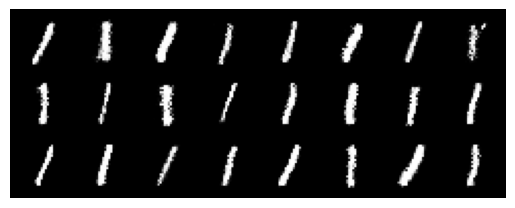

In [141]:
torch.manual_seed(1)
test_noise_bhs = get_noise(24, latent_dim_bhs, device)
generated_images_gan = trained_gan.generator(test_noise_bhs)
plot_tensor_images(generated_images_gan, num_images=24)

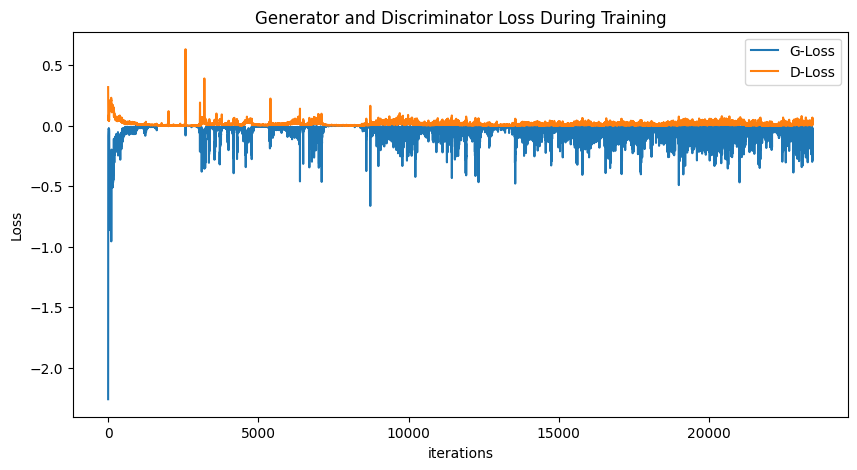

In [138]:
plot_losses(trained_gan.generator_losses, trained_gan.discriminator_losses)

In [241]:
torch.save(generator_GAN.state_dict(), "C:/Users/Rick/Desktop/bhsgan/State_Dicts/GAN_Gen.pt")
torch.save(discriminator_GAN.state_dict(), "C:/Users/Rick/Desktop/bhsgan/State_Dicts/GAN_Disc.pt")


## IPM BHS GAN

In [226]:
torch.manual_seed(96)
random.seed(96)

training_params_ipm = TrainingParams(lr_dis=0.0002, lr_gen=0.0002, num_epochs=50, num_dis_updates=4, num_gen_updates=3, beta_1=0.5, batch_size=batch_size)
generator_ipm = GeneratorIpmMnist(latent_dim).apply(init_weights)
discriminator_ipm = DiscriminatorIpmMnist(28*28).apply(init_weights)
trainer_ipm = Trainer(training_params_ipm, generator_ipm, discriminator_ipm, device=device)

In [227]:
# training loop
trained_ipmgan = trainer_ipm.train_gan(dataloader, get_dis_loss_ipm, get_gen_loss_ipm, False, flatten_dim=28*28)

Epoch 1 start training...
Epoch: 1/50 Total Steps:469poch_Run_Time: 13.806820	Loss_C : -29.872018	Loss_G : -6.364963		
Total_Time : 13.806820
Loss_C : -29.872018
Loss_G : -6.364963
Loss_C_Mean : -18.869481
Loss_G_Mean : -2.002932

----------------------------------------------

Epoch 2 start training...
Epoch: 2/50 Total Steps:938poch_Run_Time: 13.669815	Loss_C : -27.949175	Loss_G : -33.550549	
Total_Time : 13.670816
Loss_C : -27.949175
Loss_G : -33.550549
Loss_C_Mean : -16.570898
Loss_G_Mean : -44.459380

----------------------------------------------

Epoch 3 start training...
Epoch: 3/50 Total Steps:1407och_Run_Time: 13.429141	Loss_C : -7.566180	Loss_G : -60.432163		
Total_Time : 13.429141
Loss_C : -7.566180
Loss_G : -60.432163
Loss_C_Mean : -10.586425
Loss_G_Mean : -59.355927

----------------------------------------------

Epoch 4 start training...
Epoch: 4/50 Total Steps:1876och_Run_Time: 14.139705	Loss_C : -9.696076	Loss_G : -104.303329		
Total_Time : 14.140705
Loss_C : -9.69607

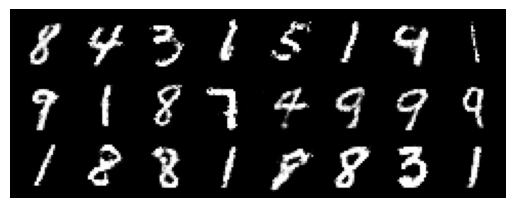

In [228]:
# show generated images
torch.manual_seed(14)
test_noise = get_noise(24, latent_dim, device)
generated_images_ipm = trained_ipmgan.generator(test_noise)
plot_tensor_images(generated_images_ipm, num_images=24)

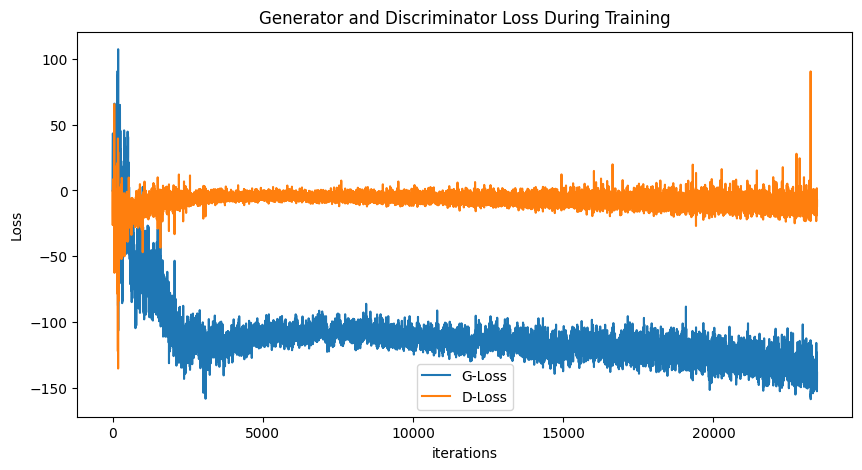

In [229]:
# plot losses
plot_losses(trained_ipmgan.generator_losses, trained_ipmgan.discriminator_losses)

In [ ]:
torch.save(generator_i.state_dict(), "C:/Users/Rick/Desktop/bhsgan/State_Dicts/RKL_Gen.pt")
torch.save(discriminator_RKL.state_dict(), "C:/Users/Rick/Desktop/bhsgan/State_Dicts/RKL_Disc.pt")